In [1]:
%matplotlib inline


# Scalability of Approximate Nearest Neighbors


This example studies the scalability profile of approximate 10-neighbors
queries using the LSHForest with ``n_estimators=20`` and ``n_candidates=200``
when varying the number of samples in the dataset.

The first plot demonstrates the relationship between query time and index size
of LSHForest. Query time is compared with the brute force method in exact
nearest neighbor search for the same index sizes. The brute force queries have a
very predictable linear scalability with the index (full scan). LSHForest index
have sub-linear scalability profile but can be slower for small datasets.

The second plot shows the speedup when using approximate queries vs brute force
exact queries. The speedup tends to increase with the dataset size but should
reach a plateau typically when doing queries on datasets with millions of
samples and a few hundreds of dimensions. Higher dimensional datasets tends to
benefit more from LSHForest indexing.

The break even point (speedup = 1) depends on the dimensionality and structure
of the indexed data and the parameters of the LSHForest index.

The precision of approximate queries should decrease slowly with the dataset
size. The speed of the decrease depends mostly on the LSHForest parameters and
the dimensionality of the data.



In [2]:
from __future__ import division
print(__doc__)

# Authors: Maheshakya Wijewardena <maheshakya.10@cse.mrt.ac.lk>
#          Olivier Grisel <olivier.grisel@ensta.org>
#
# License: BSD 3 clause

Automatically created module for IPython interactive environment


Index size: 1000, exact: 0.001s, LSHF: 0.006s, speedup: 0.1, accuracy: 1.00 +/-0.00
Index size: 2511, exact: 0.003s, LSHF: 0.007s, speedup: 0.4, accuracy: 1.00 +/-0.00
Index size: 6309, exact: 0.007s, LSHF: 0.009s, speedup: 0.8, accuracy: 1.00 +/-0.00
Index size: 15848, exact: 0.014s, LSHF: 0.010s, speedup: 1.4, accuracy: 1.00 +/-0.00
Index size: 39810, exact: 0.031s, LSHF: 0.009s, speedup: 3.4, accuracy: 0.96 +/-0.05
Index size: 100000, exact: 0.075s, LSHF: 0.014s, speedup: 5.4, accuracy: 0.96 +/-0.08


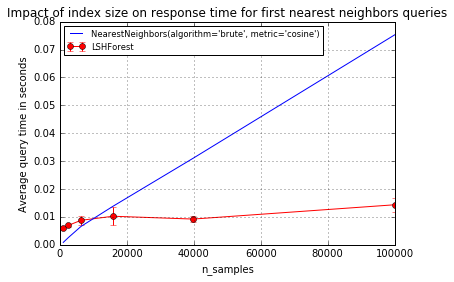

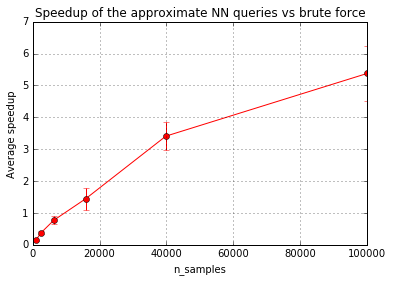

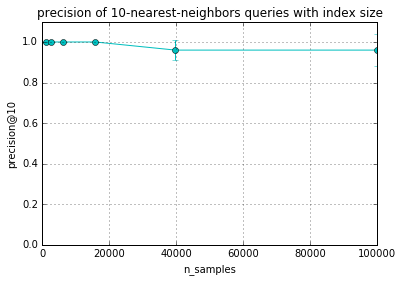

In [3]:
import time
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import LSHForest
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Parameters of the study
n_samples_min = int(1e3)
n_samples_max = int(1e5)
n_features = 100
n_centers = 100
n_queries = 100
n_steps = 6
n_iter = 5

# Initialize the range of `n_samples`
n_samples_values = np.logspace(np.log10(n_samples_min),
                               np.log10(n_samples_max),
                               n_steps).astype(np.int)

# Generate some structured data
rng = np.random.RandomState(42)
all_data, _ = make_blobs(n_samples=n_samples_max + n_queries,
                         n_features=n_features, centers=n_centers, shuffle=True,
                         random_state=0)
queries = all_data[:n_queries]
index_data = all_data[n_queries:]

# Metrics to collect for the plots
average_times_exact = []
average_times_approx = []
std_times_approx = []
accuracies = []
std_accuracies = []
average_speedups = []
std_speedups = []

# Calculate the average query time
for n_samples in n_samples_values:
    X = index_data[:n_samples]
    # Initialize LSHForest for queries of a single neighbor
    lshf = LSHForest(n_estimators=20, n_candidates=200,
                     n_neighbors=10).fit(X)
    nbrs = NearestNeighbors(algorithm='brute', metric='cosine',
                            n_neighbors=10).fit(X)
    time_approx = []
    time_exact = []
    accuracy = []

    for i in range(n_iter):
        # pick one query at random to study query time variability in LSHForest
        query = queries[[rng.randint(0, n_queries)]]

        t0 = time.time()
        exact_neighbors = nbrs.kneighbors(query, return_distance=False)
        time_exact.append(time.time() - t0)

        t0 = time.time()
        approx_neighbors = lshf.kneighbors(query, return_distance=False)
        time_approx.append(time.time() - t0)

        accuracy.append(np.in1d(approx_neighbors, exact_neighbors).mean())

    average_time_exact = np.mean(time_exact)
    average_time_approx = np.mean(time_approx)
    speedup = np.array(time_exact) / np.array(time_approx)
    average_speedup = np.mean(speedup)
    mean_accuracy = np.mean(accuracy)
    std_accuracy = np.std(accuracy)
    print("Index size: %d, exact: %0.3fs, LSHF: %0.3fs, speedup: %0.1f, "
          "accuracy: %0.2f +/-%0.2f" %
          (n_samples, average_time_exact, average_time_approx, average_speedup,
           mean_accuracy, std_accuracy))

    accuracies.append(mean_accuracy)
    std_accuracies.append(std_accuracy)
    average_times_exact.append(average_time_exact)
    average_times_approx.append(average_time_approx)
    std_times_approx.append(np.std(time_approx))
    average_speedups.append(average_speedup)
    std_speedups.append(np.std(speedup))

# Plot average query time against n_samples
plt.figure()
plt.errorbar(n_samples_values, average_times_approx, yerr=std_times_approx,
             fmt='o-', c='r', label='LSHForest')
plt.plot(n_samples_values, average_times_exact, c='b',
         label="NearestNeighbors(algorithm='brute', metric='cosine')")
plt.legend(loc='upper left', prop=dict(size='small'))
plt.ylim(0, None)
plt.ylabel("Average query time in seconds")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("Impact of index size on response time for first "
          "nearest neighbors queries")

# Plot average query speedup versus index size
plt.figure()
plt.errorbar(n_samples_values, average_speedups, yerr=std_speedups,
             fmt='o-', c='r')
plt.ylim(0, None)
plt.ylabel("Average speedup")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("Speedup of the approximate NN queries vs brute force")

# Plot average precision versus index size
plt.figure()
plt.errorbar(n_samples_values, accuracies, std_accuracies, fmt='o-', c='c')
plt.ylim(0, 1.1)
plt.ylabel("precision@10")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("precision of 10-nearest-neighbors queries with index size")

plt.show()